## Importing Libraries and data

In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from wordcloud import WordCloud
from tqdm.notebook import tqdm

In [2]:
os.listdir('../input/riiid-test-answer-prediction')

['lectures.csv',
 'example_test.csv',
 'example_sample_submission.csv',
 'train.csv',
 'questions.csv',
 'riiideducation']

In [3]:
train_df = pd.read_csv('../input/riiid-test-answer-prediction/train.csv', nrows=1000000)
lectures = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')
questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
example_test = pd.read_csv('../input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('../input/riiid-test-answer-prediction/example_sample_submission.csv')

## Before anything else let's see what is our target

In [4]:
example_sample_submission.head(2)

,row_id,answered_correctly,group_num
0,0,0.5,0
1,1,0.5,0


In [5]:
example_test.head(2)

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN


#### Just in case you are wondering why a example_test file then the reason is that the actual test file could only be seen from the time series api of the riid. rest info is here - https://www.kaggle.com/sohier/competition-api-detailed-introduction 

#### OK!! So we basically have to predict a probability for "answered_correctly" for a given "row_id" and "group_num" With that out of the way let's look at our training data

#### Also the evaluation metric is area under the ROC curve.

In [6]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [7]:
if len(train_df) == len(train_df.row_id.unique()):
    print('row_id column is the key')

row_id column is the key


In [8]:
print('total train samples ', len(train_df))

total train samples  1000000


## Understanding The Problem

#### So this is a binary classification and timeseries problem where you predict "ansered_correctly" by a student "user_id" over time "timestamp".

we have been provided with `content_id` column which tells us user interestion with the content (not entirely sure wheather its like a book id fixed for that book for all user's or a id generated for each interaction but we will see it later on.), also we have a `content_type_id` column in which 0 means he answered a question and 1 means the content was a lecture and hence he watched a lecture. If he watched a lecture then there was no question hence we need not predict the `answered_correctly` and skip the row for prediction.

Next, we have `task_container_id` columns which means id's for set's of questions. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a `task_container_id`. ( A correlation/similarity is in a column `bundle_id` from `question.csv` file)

Upnext, we have `user_answer` column where user gives a MCQ type answer say 1,2 or 3 etc. and whether that answer was correct or not is recorded in the next `answered_correctly` column which we need to predict.

Upnext, we have `prior_question_elapsed_time` column which tells how long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle. (so it depends on the number of questions that bundle had).

At the last we have `prior_question_had_explanation` (bool) column which tells whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback. ( In case the questions are related then this can help much.)

## Analizing the train.csv file

In [9]:
print("No of students = ", len(train_df['user_id'].unique()))

No of students =  3824


Text(0.5, 1.0, 'label distribution')

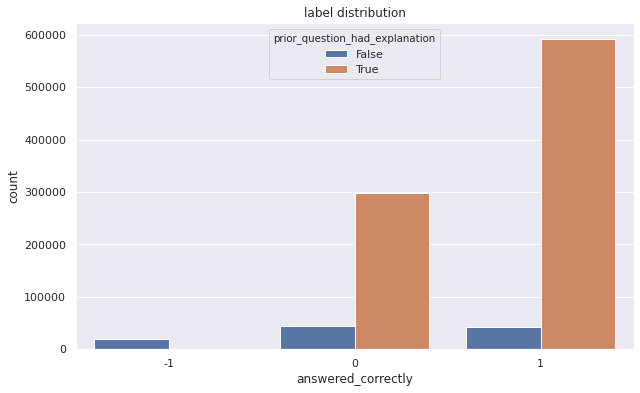

In [10]:
# idstribution of class labels
sns.set()
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, x='answered_correctly', hue='prior_question_had_explanation')
plt.title('label distribution')

So, there is class imbalance. This is first time I am happy to see class Imbalance. This means that student do study and get more correct_answers. KEEP IT UP BOYS. Make it more imbalanced. <br>
The number of data samples is too much so class imbalance doesn't matter to that extent.

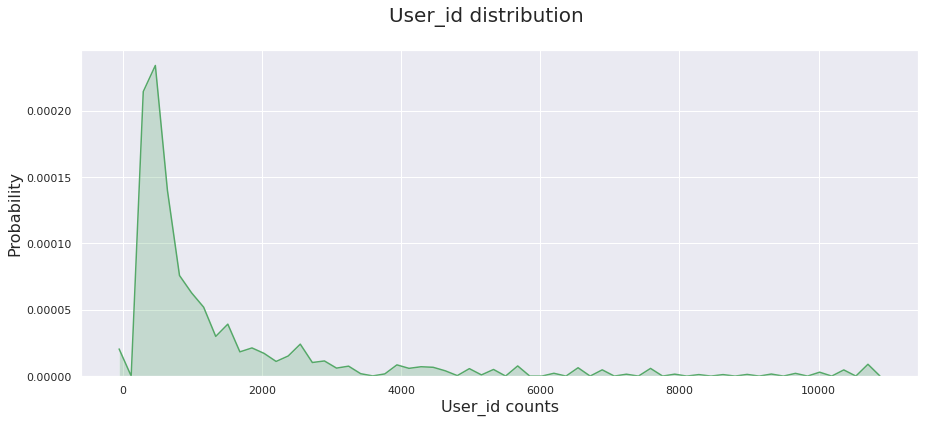

In [11]:
# distribution of number of samples per student
sns.set()
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(train_df.groupby(by='user_id').count()['row_id'], shade=True, gridsize=50, color='g', legend=False)
fig.figure.suptitle("User_id distribution", fontsize = 20)
plt.xlabel('User_id counts', fontsize=16)
plt.ylabel('Probability', fontsize=16);

So, most of the students have < 2K samples.

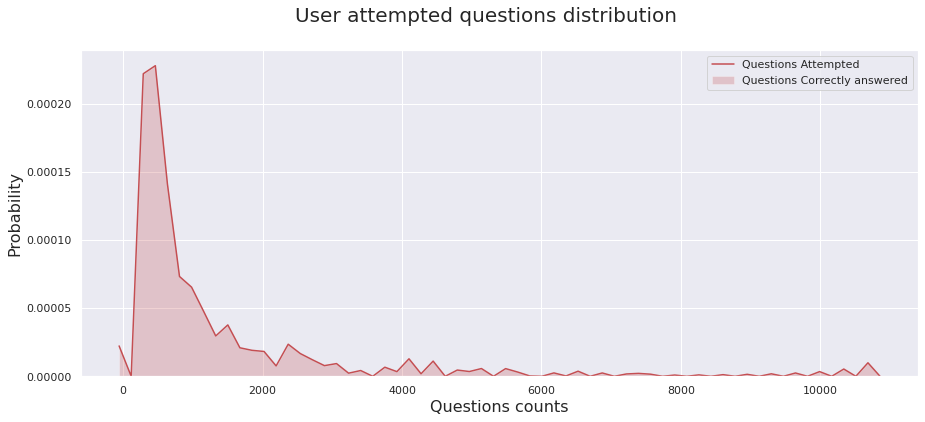

In [12]:
# How many question does each student attempt
df = train_df[train_df['content_type_id'] == 0]

df = df.groupby(by='user_id').count()

fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(df['row_id'], shade=True, gridsize=50, color='r', legend=False)
fig.figure.suptitle("User attempted questions distribution", fontsize = 20)
plt.xlabel('Questions counts', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.legend(['Questions Attempted','Questions Correctly answered'])

So they follow the same distribution. Majority of student have attempted < 2K questions.

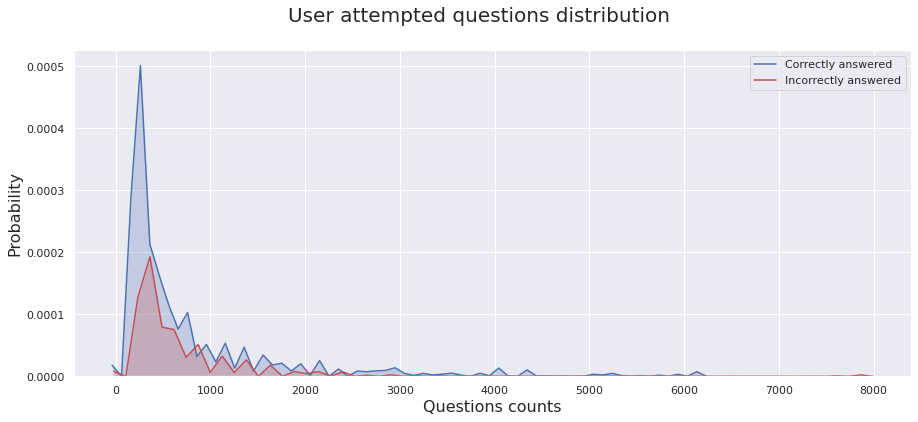

In [13]:
# distribution of correct and incorrect and no answers
df = train_df[train_df['content_type_id'] == 0]

df2 = df[df['answered_correctly'] == 1]
df3 = df[df['answered_correctly'] == 0]

df2 = df2.groupby(by='user_id').count()
df3 = df3.groupby(by='user_id').count()

fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(df2['row_id'], shade=True, gridsize=50, color='b', legend=False)
fig = sns.kdeplot(df3['row_id'], shade=True, gridsize=50, color='r', legend=False)

fig.figure.suptitle("User attempted questions distribution", fontsize = 20)
plt.xlabel('Questions counts', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.legend(['Correctly answered','Incorrectly answered'])

So we can see that the probability of ansering correctly is mostly 2.5 times that of answering incorrectly.

In [14]:
# What is the distribution of students correctly answering a question
values = []

df = train_df[train_df['content_type_id'] == 0]

for group, frame in df.groupby(by='user_id'):
    
    value = len(frame[frame['answered_correctly'] == 1]) / len(frame)
    values.append(value)

MEAN:  0.5451481297427322
MAX:  1.0
MIN:  0.0


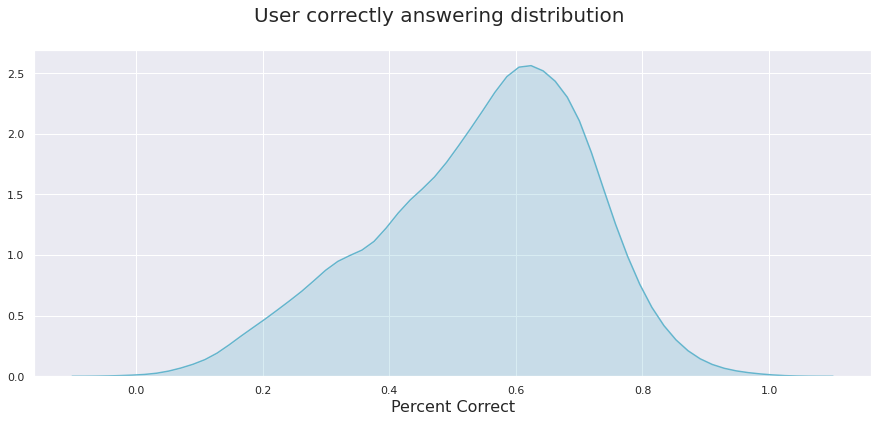

In [15]:
fig = plt.figure(figsize=(15,6))
fig = sns.kdeplot(values, shade=True, gridsize=50, color='c', legend=False)
fig.figure.suptitle("User correctly answering distribution", fontsize = 20)
plt.xlabel('Percent Correct', fontsize=16)

print('MEAN: ', np.mean(values))
print("MAX: ", np.max(values))
print('MIN: ', np.min(values))

the graph shows that the average accuracy of a student is near 54% in answering correctly. Some have scored perfect and some have scored zero. (We have outliars as getting all zeros is by probability as hard as getting all correct so we have to handle that)

In [16]:
# What precent of students see explanations

values = []

df = train_df[train_df['content_type_id'] == 0]

for group, frame in df.groupby(by='user_id'):
    
    value = len(frame[frame['prior_question_had_explanation'] == True]) / len(frame)
    values.append(value)

Text(0, 0.5, 'Counts')

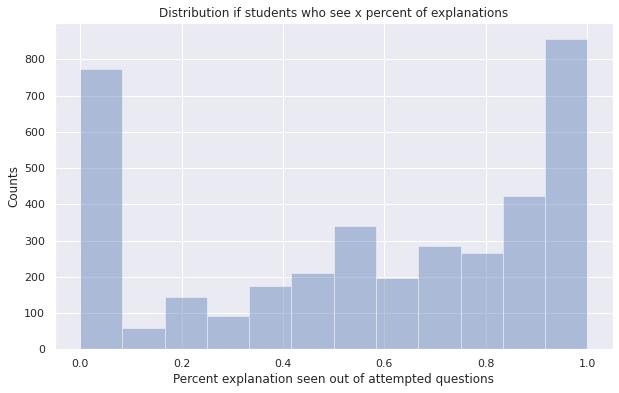

In [17]:
plt.figure(figsize=(10,6))
sns.distplot(values, kde=False)
plt.title('Distribution if students who see x percent of explanations')
plt.xlabel('Percent explanation seen out of attempted questions')
plt.ylabel('Counts')

There is a considerable amount of students who never watched prior explanations and yet answered correctly. Any further than this we will need to use timestamps or other files.

In [18]:
print("Total task container id's having questions: ", len((train_df['task_container_id'][train_df['content_type_id'] == 0]).unique()))

Total task container id's having questions:  7740


### Before we move into the real EDA which is with respect to time_stamp let's have a look at questions and lectures files

## Questions file

In [19]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


`question_id`: foreign key for the train/test content_id column, when the content type is question (0).

`bundle_id`: code for which questions are served together.

`correct_answer`: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

`part`: top level category code for the question.

`tags`: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [20]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [21]:
print('Total number of questions: ', len(questions['question_id'].unique()))
print("Total number of unique bundles: ", len(questions['bundle_id'].unique()))

Total number of questions:  13523
Total number of unique bundles:  9765


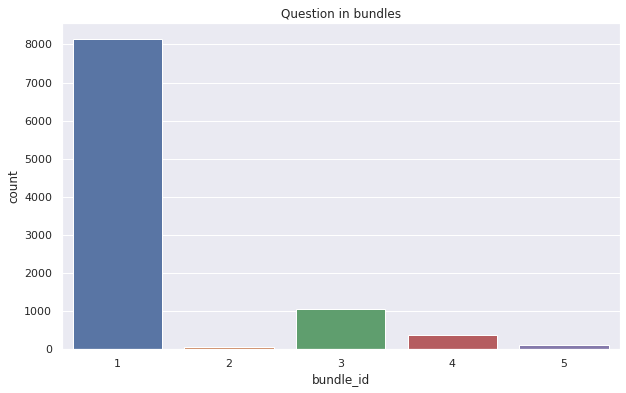

In [22]:
fig = plt.figure(figsize=(10,6))
fig = sns.countplot(questions.groupby(by='bundle_id').count()['question_id'])
plt.xlabel('bundle_id')
plt.title('Question in bundles');

Well I think that the majority of the question sets in task_container_id is from bundle 1

Text(0.5, 1.0, 'Correct Answers distribution')

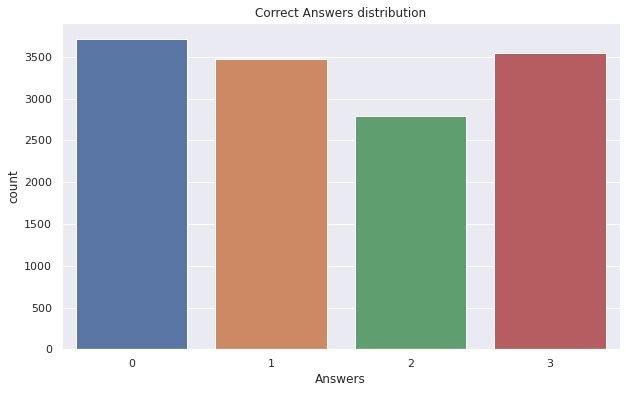

In [23]:
fig = plt.figure(figsize=(10,6))
fig = sns.countplot(questions['correct_answer'])
plt.xlabel('Answers')
plt.title('Correct Answers distribution')

So the answers almost have a uniform distribution.

In [24]:
# Distribution of number of tags per question
# I think of tags as subject includings like (maths, algebra, numbers. history etc. in encoded form)

no_of_tags = []
for i in questions['tags']:
    value = len(str(i).strip().split(' '))
    no_of_tags.append(value)

Text(0.5, 1.0, 'No of tags per question')

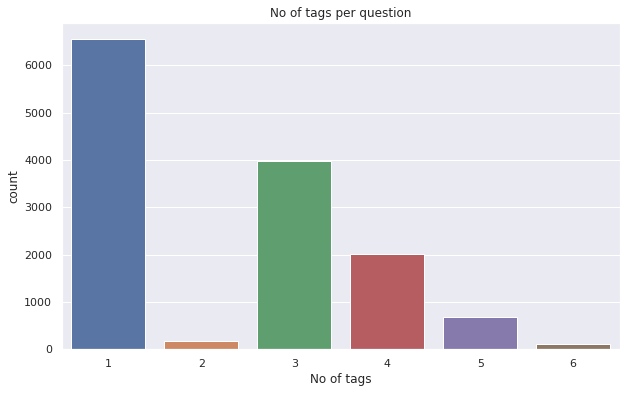

In [25]:
plt.figure(figsize=(10,6))
sns.countplot(no_of_tags)
plt.xlabel('No of tags')
plt.title('No of tags per question')

Quite Superising that the number of tags is not decreasing constantly but has a huge dip at 2.

In [26]:
# distribution of tags

total = []

for i in questions['tags']:
    for j in str(i).strip().split(' '):
        total.append(j)
        
keys = set(total)
final = {}
for i in keys:
    final[i] = total.count(i)
    
values = sorted(final.items(), key=lambda x: x[1], reverse=True)
d = []
for i in values:
    d.append(i[1])

In [27]:
plt.figure(figsize=(10,6))
px.line(d, title='Tags distribution')

<Figure size 720x432 with 0 Axes>

The distribution of tags is very skewed. Only 40 tags occur almost > 80% of time. If we want to decrease the sparcity of our data we could use only the top 100 tags and it would be more than 95% of total tags with only 50% sparcity.


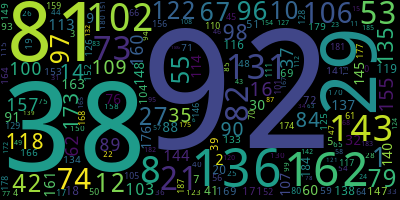

In [28]:
# Most commmon tags
tags = WordCloud().generate_from_frequencies(final)
px.imshow(tags, title='Most frequent Tags')

## lectures file

In [29]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,24584,5,concept
1,100,22243,1,concept
2,185,7035,6,concept
3,192,31458,5,solving question
4,317,19653,5,solving question


`lecture_id`: foreign key for the train/test content_id column, when the content type is lecture (1).

`part`: top level category code for the lecture. (This confuses me. If we have tag then why do we need part?)

`tag`: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

`type_of`: brief description of the core purpose of the lecture

In [30]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [31]:
print('Total no. of lectures: ', len(lectures['lecture_id'].unique()))
print('Only one tag per row: ', )
print('Total no. of tags in lecture: ', len(lectures['tag'].unique()))

Total no. of lectures:  418
Only one tag per row: 
Total no. of tags in lecture:  151


Now comes the troubling part. Tags in lectures has no relation with tags in questions and hence they could be different altogether.

In [32]:
# distribution of lecture tags

total = []

for i in lectures['tag']:
    for j in str(i).strip().split(' '):
        total.append(j)
        
keys = set(total)
final = {}
for i in keys:
    final[i] = total.count(i)
    
values = sorted(final.items(), key=lambda x: x[1], reverse=True)
d = []
for i in values:
    d.append(i[1])

In [33]:
plt.figure(figsize=(10,6))
px.line(d, title='Tags distribution')

<Figure size 720x432 with 0 Axes>

Now that is some amazing pattern. The first idea is that the tags could be like subject title. Like lectures with high importance comes from a important chapter and that chapter may have only certen types of tags. Say math chapter may have (Maths, numbers, Algebra) as tags(encoded). 


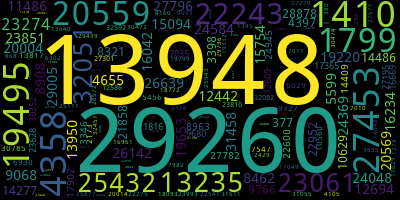

In [34]:
# Most common tags
tags = WordCloud().generate_from_frequencies(final)
px.imshow(tags, title='Most frequent lecture Tags')

In [35]:
# Looking at parts
print('Total type of parts: ', len(lectures.part.unique()))
print('Values of parts: ', lectures.part.unique())

Total type of parts:  7
Values of parts:  [5 1 6 2 7 3 4]


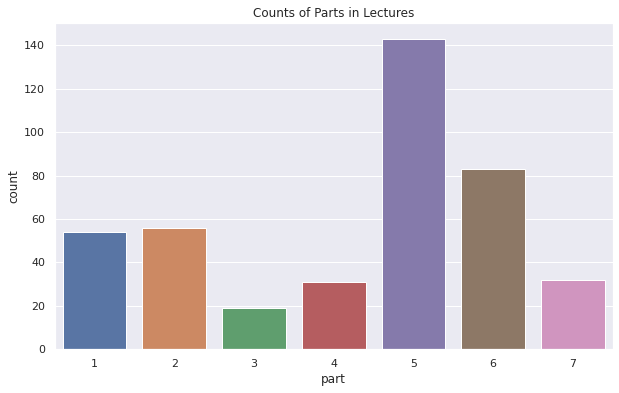

In [36]:
# Counts of parts
plt.figure(figsize=(10,6))
sns.countplot(lectures['part'])
plt.title('Counts of Parts in Lectures');

In [37]:
# how many different unique tags does each part have or do they common tags as well ?

no_unique_tags_l = []
unique_tags_l = {}
groups = []

for group, frame in lectures.sort_values(by='part').groupby(by='part'):
    
    unique_tags = frame['tag'].unique()
    no_unique_tags = len(unique_tags)
    
    unique_tags_l[group] = unique_tags
    no_unique_tags_l.append(no_unique_tags)
    groups.append(group)
    
no_unique_tags_l = pd.DataFrame(no_unique_tags_l, columns=['count'])
no_unique_tags_l['group'] = groups

Text(0.5, 1.0, 'No. of unique tags in each part')

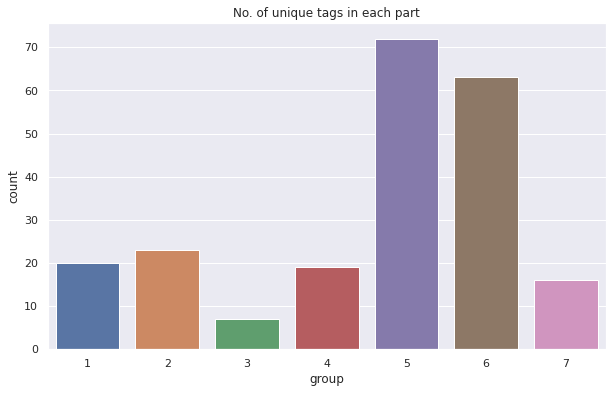

In [38]:
# Number of unique tags in each part ( here unique means internally part wise)
plt.figure(figsize=(10,6))
sns.barplot(x=no_unique_tags_l['group'], y=no_unique_tags_l['count'])
plt.title('No. of unique tags in each part')

So, it also follow the same distribution as above.

In [39]:
final_unqiue = []
parts = []


for part, array in unique_tags_l.items():
    
    unique_tags = []
        
    other_parts = list(unique_tags_l.keys())
    final = set(other_parts)
    final.remove(part)
    
    for j in final:
        
        for k in array:
            
            if k not in unique_tags_l[j]:
                
                unique_tags.append(k)
    
    final_unqiue.append(len(unique_tags))
    parts.append(part)
    
final_unqiue = pd.DataFrame(final_unqiue, columns=['tags'])
final_unqiue['part'] = parts

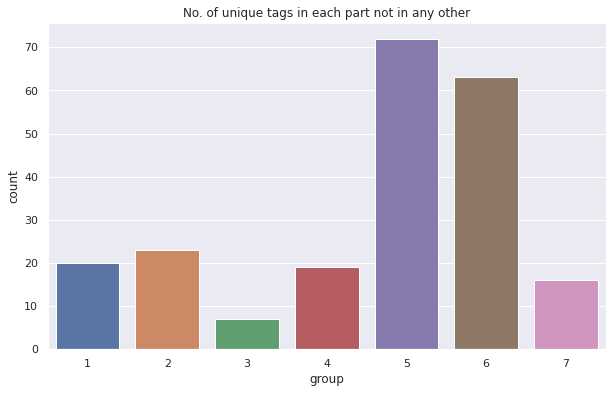

In [40]:
# let's see how many tags are there in each part which are not in any other part

plt.figure(figsize=(10,6))
sns.barplot(x=no_unique_tags_l['group'], y=no_unique_tags_l['count'])
plt.title('No. of unique tags in each part not in any other');

So, we could rest assured that one tag comes only in one part.

In [41]:
# Finally let's look at type_of lectures

px.bar(lectures, x='type_of', color=lectures['type_of'], labels={'value':'type_of'}, title='Type of lectures distribution Overall')

In [42]:
px.bar(lectures, x='type_of', color=lectures['type_of'], labels={'value':'type_of'}, title='Type of lectures distribution based on each part', facet_col='part')

Suprisingly intention belongs to only one part and starter is only in 2 parts.

## Now it's time to use the time stamp and see a few students from train file

In [43]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [44]:
# we will see first 8 students for trends
no_students = 8
scores = []
user_ids = []
question_attempted_l = []
correctly_answered_l = []
prior_questions_explanations = []

for count, (group, frame) in enumerate(train_df.groupby(by='user_id')):
    
    if count == no_students:
        break
    
    frame = frame.sort_values(by='timestamp')
    
    percentage = []
    question_attempted = []
    correctly_answered = []
    explanations = []
    attempted = 0
    correct_answers = 0
    explanation = 0
    
    df = frame[frame['content_type_id'] == 0]
    
    for answered_correctly, had_explanation in zip(df['answered_correctly'], df['prior_question_had_explanation']):
        
        attempted += 1
        question_attempted.append(attempted)
        
        if answered_correctly == 1:
            correct_answers += 1
            
        if had_explanation:
            explanation += 1
            
        correctly_answered.append(correct_answers)
            
        percent = correct_answers / attempted * 100
        percentage.append(percent)
        explanations.append(explanation)
        
    
    scores.append(percentage)
    user_ids.append(group)
    question_attempted_l.append(question_attempted)
    correctly_answered_l.append(correctly_answered)
    prior_questions_explanations.append(explanations)

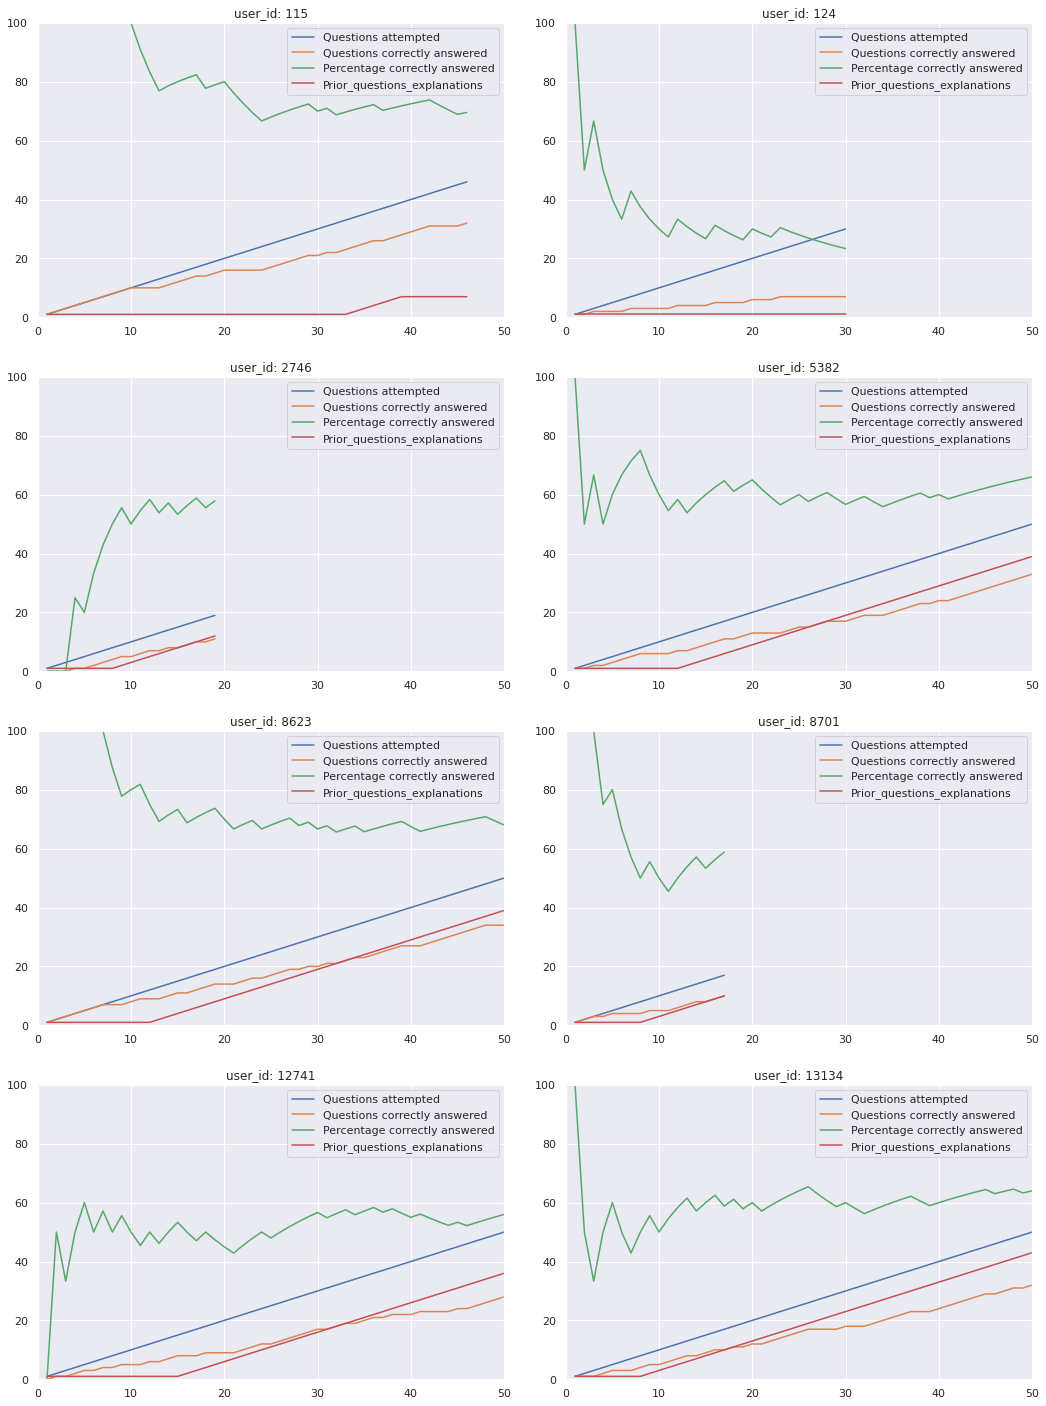

In [45]:
# Trend in attempted question and correctly answering

plt.figure(figsize=(15,20))

for i in range(1,9):
    plt.subplot(4,2,i)
    plt.plot(question_attempted_l[i-1], question_attempted_l[i-1], label='Questions attempted')
    plt.plot(question_attempted_l[i-1], correctly_answered_l[i-1], label='Questions correctly answered')
    plt.plot(question_attempted_l[i-1], scores[i-1], label='Percentage correctly answered')
    plt.plot(question_attempted_l[i-1], prior_questions_explanations[i-1], label='Prior_questions_explanations')
    plt.legend()
    plt.ylim(0,100)
    plt.xlim(0,50)
    plt.tight_layout(pad = 2)
    plt.title(f'user_id: {user_ids[i-1]}')

So much to see. So much trends and patterns. Well those who had prior explanation had better results. So the trend has many types. sudden spikes(+ve, -ve), consistency, continuous increment, decrement.<br>
Bad Students: Almost no one started watching explanations until they started performing bad.

In [46]:
# Does students time spend on answering prior questions

no_students = 8
time_spend_l = []

for count, (group, frame) in enumerate(train_df.groupby(by='user_id')):
    
    if count == no_students:
        break
    
    frame = frame.sort_values(by='timestamp')
    total_time_spends = []
    time_spends = 0
    
    for time_spend in frame['prior_question_elapsed_time'][frame['content_type_id'] == 0]:
        
        if time_spend > 0:
            time_spends += time_spend
            total_time_spends.append(time_spends)
        
    
    time_spend_l.append(total_time_spends)

In [47]:
time_spend_l = np.array(time_spend_l)
for index, value in enumerate(time_spend_l):
    time_spend_l[index] = np.array(time_spend_l[index]) / 10000

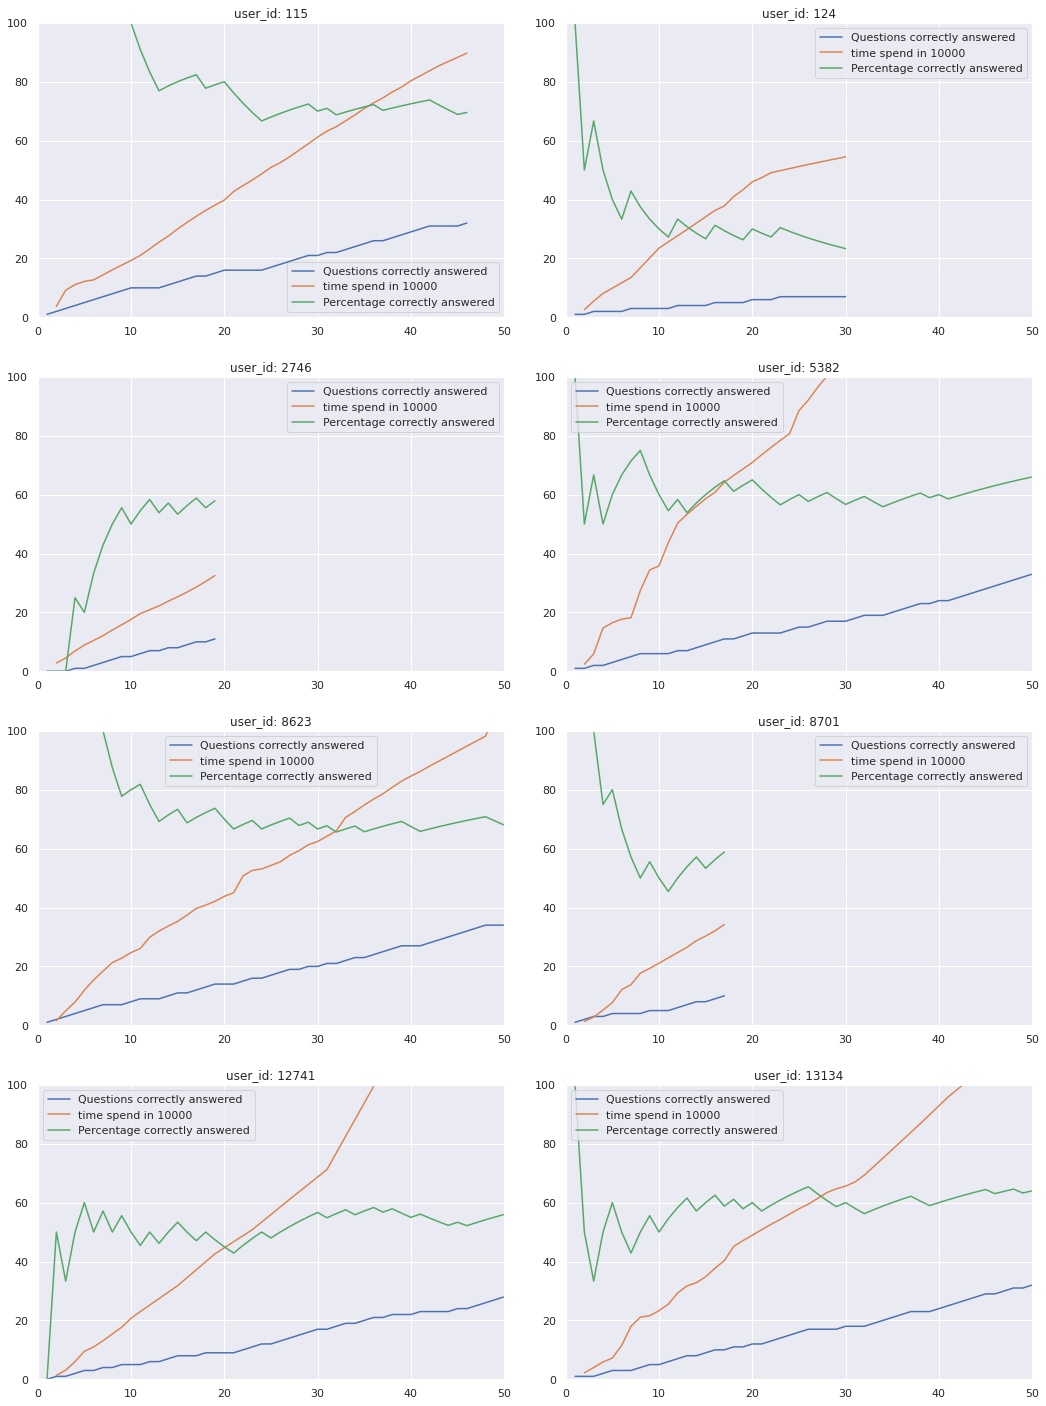

In [48]:
# Trend in time spend with percentage

plt.figure(figsize=(15,20))

for i in range(1,9):
    plt.subplot(4,2,i)
    plt.plot(question_attempted_l[i-1], correctly_answered_l[i-1], label='Questions correctly answered')
    plt.plot(question_attempted_l[i-1][1:], time_spend_l[i-1], label='time spend in 10000')
    plt.plot(question_attempted_l[i-1], scores[i-1], label='Percentage correctly answered')
    plt.legend()
    plt.ylim(0,100)
    plt.xlim(0,50)
    plt.tight_layout(pad = 2)
    plt.title(f'user_id: {user_ids[i-1]}')

There is mostly a linear increase in prior question time elapsed.

In [49]:
print('Correlation among variables of train file')
train_df.corr().style.background_gradient(cmap='Blues')

Correlation among variables of train file


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
row_id,1.000000,-0.000843,0.999057,-0.006783,0.004011,-0.071142,-0.002382,-0.015589,0.016242
timestamp,-0.000843,1.000000,-0.001041,0.032189,0.007441,0.364525,-0.001796,0.027571,0.016144
user_id,0.999057,-0.001041,1.000000,-0.007103,0.004102,-0.072862,-0.002361,-0.014776,0.016981
content_id,-0.006783,0.032189,-0.007103,1.000000,0.420121,0.062908,-0.110374,-0.203327,0.149778
content_type_id,0.004011,0.007441,0.004102,0.420121,1.000000,-0.013024,-0.283418,-0.438788,nan
task_container_id,-0.071142,0.364525,-0.072862,0.062908,-0.013024,1.000000,0.012135,0.039130,-0.043670
user_answer,-0.002382,-0.001796,-0.002361,-0.110374,-0.283418,0.012135,1.000000,0.126721,0.014283
answered_correctly,-0.015589,0.027571,-0.014776,-0.203327,-0.438788,0.039130,0.126721,1.000000,0.003251
prior_question_elapsed_time,0.016242,0.016144,0.016981,0.149778,nan,-0.043670,0.014283,0.003251,1.000000


## Modelling the data (basic)

Now we have to make models on our data, but we have far too much data. first let's free some memory.

In [50]:
for element in dir():
    if element[0:2] != "__":
        del globals()[element]

### Steps to model the data <br>
    * Integrate information from lectures and questions file to training file
    * Select only those columns which are questions and make a column named prior_thing(bool)(0 = question 1 =lecture)
    * Make a new column named prior_type(categorical)(if prior_thing is 0 then 'question' else the type_of values from lecture file
    * Now we can drop columns which are not questions
    * We add another columns which is correct_answer and it will also be available in the test data
    * Use user_answer column as label column
    * Select user_id's with more than 30 columns and make a batch of each user_id to feed for training

For simplicity we will consider only the first tag.

## Importing Libraries and data again

In [51]:
import os
import gc
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm as lgb
from multiprocessing import Pool

In [52]:
lectures = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')
questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')

In [53]:
train_df = pd.read_csv("../input/riiid-test-answer-prediction/train.csv",
                        chunksize=500000)

As lecture_id and question_id are foreign keys so the number of content_id should be equal to number of lecture_id + number of question_id

In [54]:
print("Making Mapping dictionaries: \n")

conversion1 = {}
conversion2 = {}
conversion3 = {}
conversion4 = {}

for i in tqdm(lectures['lecture_id']):
    conversion1[i] = lectures['tag'][lectures['lecture_id'] == i].values[0]
    conversion2[i] = lectures['part'][lectures['lecture_id'] == i].values[0]
    conversion3[i] = lectures['type_of'][lectures['lecture_id'] == i].values[0]
    conversion4[i] = -1

for i in tqdm(questions['question_id']):
    conversion1[i] = questions['tags'][questions['question_id'] == i].values[0]
    conversion2[i] = questions['part'][questions['question_id'] == i].values[0]
    conversion3[i] = 'question'
    conversion4[i] = questions['correct_answer'][questions['question_id'] == i].values[0]

Making Mapping dictionaries: 



In [55]:
def preprocess_train(df, count):
    
    df['tags'] = df['content_id'].map(conversion1)
    df['part'] = df['content_id'].map(conversion2)
    
    df = (df.assign(tags = df['tags'].str.strip().str.split(' '))
         .explode('tags')
         .reset_index(drop=True))
    
    df.fillna(value=-1, inplace=True)
    
    df['prior_thing'] = 0
    
    for group, frame in df.groupby(by='user_id'):

        frame = frame.sort_values(by='timestamp')
        frame['prior_thing'] = frame['content_type_id'].shift(1)

    df['prior_type'] = 'question'
    
    df['prior_type'] = df['content_id'].map(conversion3)
    
    for group, frame in df.groupby(by='user_id'):

        frame = frame.sort_values(by='timestamp')
        frame['prior_type'] = frame['prior_type'].shift(1)
    
    # Now after extracting information we will drop all columns other than those with questions
    df = df[df['content_type_id'] == 0]
    
    df['correct_answer'] = df['content_id'].map(conversion4)

    df.drop(columns = ['row_id', 'content_type_id', 'user_answer', 'content_id'], inplace=True)
    
    df.fillna(value=-1, inplace=True)
    
    df['tags'] = df['tags'].astype(np.float32)

    
    le1 = preprocessing.LabelEncoder()
    le2 = preprocessing.LabelEncoder()

    df['prior_question_had_explanation'] = le1.fit_transform(df['prior_question_had_explanation'])
    df['prior_type'] = le2.fit_transform(df.loc[:, 'prior_type'].values)
    
    return df, le1, le2

## Making a model

Though I will be making a simple train test split you should make validation by grouping the data by user_id and then sorting by timestamp and choosing the last index values in the validation.

In [56]:
categorical_features = ['user_id', 'task_container_id', 'prior_question_had_explanation', 'tags', 'part',
                       'prior_thing', 'correct_answer']

model = None
count = 0

params = {
    'keep_training_booster' : True,
    'objective': 'binary',
    'verbose':100,
    'learning_rate': 0.1,
}

# I we will run the model for 2 rounds, you could run it for more. (It takes time)

for df in train_df:
    
    if count == 2:
        break
        

    
    df, le1, le2 = preprocess_train(df, count)
    
    count += 1
    
  
    xtrain, xvalid, ytrain, yvalid = train_test_split(df.drop(columns='answered_correctly'),
                                                     df['answered_correctly'], test_size=0.2, random_state=1)
    
    lgb_train = lgb.Dataset(xtrain, ytrain, categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(xvalid, yvalid, categorical_feature=categorical_features)
    
    model = lgb.train(params,
            init_model=model,
            train_set=lgb_train,
            valid_sets=lgb_valid,
            verbose_eval=10,
            num_boost_round=100)
    
    print("ROC SCORE: ", roc_auc_score(yvalid, model.predict(xvalid)))
    
    del df, xtrain, ytrain, xvalid, yvalid, lgb_train, lgb_valid
    gc.collect()

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[10]	valid_0's binary_logloss: 0.589923
[20]	valid_0's binary_logloss: 0.580203
[30]	valid_0's binary_logloss: 0.575642
[40]	valid_0's binary_logloss: 0.571754
[50]	valid_0's binary_logloss: 0.569097
[60]	valid_0's binary_logloss: 0.567119
[70]	valid_0's binary_logloss: 0.565224
[80]	valid_0's binary_logloss: 0.562826
[90]	valid_0's binary_logloss: 0.561216
[100]	valid_0's binary_logloss: 0.55963
ROC SCORE:  0.7146977438022706


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[110]	valid_0's binary_logloss: 0.59926
[120]	valid_0's binary_logloss: 0.592514
[130]	valid_0's binary_logloss: 0.589144
[140]	valid_0's binary_logloss: 0.586139
[150]	valid_0's binary_logloss: 0.583503
[160]	valid_0's binary_logloss: 0.581186
[170]	valid_0's binary_logloss: 0.57867
[180]	valid_0's binary_logloss: 0.57664
[190]	valid_0's binary_logloss: 0.574805
[200]	valid_0's binary_logloss: 0.573151
ROC SCORE:  0.7068927240989753


#### I NEED MORE, MUCH MORE RAM

## KINDLY UPVOTE. Also try to use this for riiideducation prediction as exercise.